#  Analyse statistique – EL AMAL HUILERIE
## Data Exploration


## Introduction
Ce projet a pour objectif d’analyser les données de production et de prix
au sein de la société **EL AMAL HUILERIE**.

L’analyse comprend :
- le nettoyage des données brutes,
- une étude statistique descriptive,
- des visualisations graphiques,
- des tests statistiques et une analyse des relations entre variables.


## 0) Packages
Installation et chargement des bibliothèques nécessaires à l’analyse.


In [ ]:
# =============================
# 0) Packages
# =============================
install.packages(c("tidyverse", "readxl", "lubridate", "janitor", "scales"))
library(tidyverse)
library(readxl)
library(lubridate)
library(janitor)
library(scales)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## 1) Importation des données
Les données sont importées depuis un fichier Excel puis les noms

des colonnes sont standardisés pour faciliter l’analyse.


#

In [ ]:
# 1) Import
# =============================
df_raw <- read_excel("/content/sample_data/dataStage.xlsx")
df <- df_raw %>% clean_names()


## 2) Nettoyage des données
Cette étape consiste à :
- convertir les colonnes numériques,
- uniformiser les formats de dates,
- supprimer les doublons,
- créer de nouvelles variables utiles à l’analyse.


In [ ]:
# 2.2 Fonction utilitaire : convertir texte "12 345,6 DT" -> 12345.6
to_num_dt <- function(x) {
  x %>%
    as.character() %>%
    str_replace_all("DT", "") %>%
    str_replace_all("\\s+", "") %>%     # enlever espaces (y compris insécables)
    str_replace_all(",", ".") %>%
    suppressWarnings(as.numeric())
}

In [ ]:
# 2.3 Nettoyer colonnes numériques si elles existent
if ("qte_olive" %in% names(df))      df$qte_olive <- to_num_dt(df$qte_olive)
if ("qte_entree" %in% names(df))     df$qte_entree <- to_num_dt(df$qte_entree)
if ("prix_unitaire" %in% names(df))  df$prix_unitaire <- to_num_dt(df$prix_unitaire)
if ("prix_total" %in% names(df))     df$prix_total <- to_num_dt(df$prix_total)

# 2.4 Convertir date (ton fichier contient date_entree)
if ("date_entree" %in% names(df)) {
  df$date_entree <- parse_date_time(df$date_entree, orders = c("dmy", "ymd")) %>% as.Date()
}

In [ ]:
# 2.4 Convertir date (ton fichier contient date_entree)
if ("date_entree" %in% names(df)) {
  df$date_entree <- parse_date_time(df$date_entree, orders = c("dmy", "ymd")) %>% as.Date()
}

In [ ]:
# 2.5 Convertir colonnes texte en "character"
cols_text <- intersect(c("n_quitance", "libelle_produit", "unite", "provenance"), names(df))
df <- df %>% mutate(across(all_of(cols_text), as.character))


In [ ]:
# 2.6 Supprimer doublons sur n_quitance (garder plus récent) comme Python
if (all(c("n_quitance", "date_entree") %in% names(df))) {
  df <- df %>% arrange(date_entree) %>% distinct(n_quitance, .keep_all = TRUE)
}

In [ ]:
# 2.8 Créer qte_totale = qte_olive + qte_entree (comme Python)
if (all(c("qte_olive", "qte_entree") %in% names(df))) {
  df <- df %>% mutate(qte_totale = coalesce(qte_olive, 0) + coalesce(qte_entree, 0))
}

df_clean <- df


In [ ]:
df <- df %>%
  mutate(
    qte_olive  = suppressWarnings(as.numeric(qte_olive)),
    qte_entree = suppressWarnings(as.numeric(qte_entree))
  )
if (all(c("qte_olive", "qte_entree") %in% names(df))) {
  df <- df %>%
    mutate(
      qte_totale = coalesce(qte_olive, 0) + coalesce(qte_entree, 0)
    )
}

df_clean <- df


In [ ]:
df <- df %>%
  mutate(
    qte_totale =
      if_else(
        !is.na(as.numeric(qte_olive)) | !is.na(as.numeric(qte_entree)),
        coalesce(as.numeric(qte_olive), 0) + coalesce(as.numeric(qte_entree), 0),
        NA_real_
      )
  )


In [ ]:
#Test
str(df$qte_olive)
str(df$qte_entree)
str(df$qte_totale)
summary(df$qte_totale)


 num [1:32315] 208421 218 187 204 194 ...
 num [1:32315] 39600 39601 39602 39603 39604 ...
 num [1:32315] 248021 39819 39789 39807 39798 ...


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.879e+01 1.193e+03 1.566e+03 3.321e+03 1.917e+03 2.255e+06 

In [ ]:
df_clean <- df   # reset propre


In [ ]:
library(readr)

df_clean <- df_clean %>%
  mutate(
    prix_total_raw = as.character(prix_total),
    prix_total_num = parse_number(
      prix_total_raw,
      locale = locale(decimal_mark = ",", grouping_mark = " ")
    )
  )


In [ ]:
cat("Total lignes =", nrow(df_clean), "\n")
cat("Valeurs numériques =", sum(!is.na(df_clean$prix_total_num)), "\n")
head(df_clean %>% select(prix_total_raw, prix_total_num), 10)


Total lignes = 32315 
Valeurs numériques = 32315 


prix_total_raw,prix_total_num
<chr>,<dbl>
3168,3168
1.6544,1
1.4232,1
1.5528,1
1.4752,1
1.4376,1
1.4344,1
1.588,1
1.4528,1


In [ ]:
df_plot <- df_clean %>%
  filter(!is.na(prix_total_num), is.finite(prix_total_num))


## 3) Étude statistique descriptive
Cette partie présente les statistiques descriptives de la variable
principale ainsi que des visualisations graphiques.


In [ ]:


# 3.1 Résumé chiffres
stats_prix <- df_plot %>%
  summarise(
    nombre = n(),
    moyenne = mean(prix_total_num),
    mediane = median(prix_total_num),
    ecart_type = sd(prix_total_num),
    minimum = min(prix_total_num),
    maximum = max(prix_total_num)
  )

print(stats_prix)


# A tibble: 1 × 6
  nombre moyenne mediane ecart_type minimum maximum
   <int>   <dbl>   <dbl>      <dbl>   <dbl>   <dbl>
1  32315   3230.    3000     22900.       1 3780105


## 4) Questions d’analyse statistique
- Moyenne, médiane et variance de la variable principale
- Test de normalité (Shapiro-Wilk)
- Comparaison de deux sous-groupes (test t de Student)
- Modèle de régression linéaire simple
- Corrélation entre deux variables


### Distribution du prix total


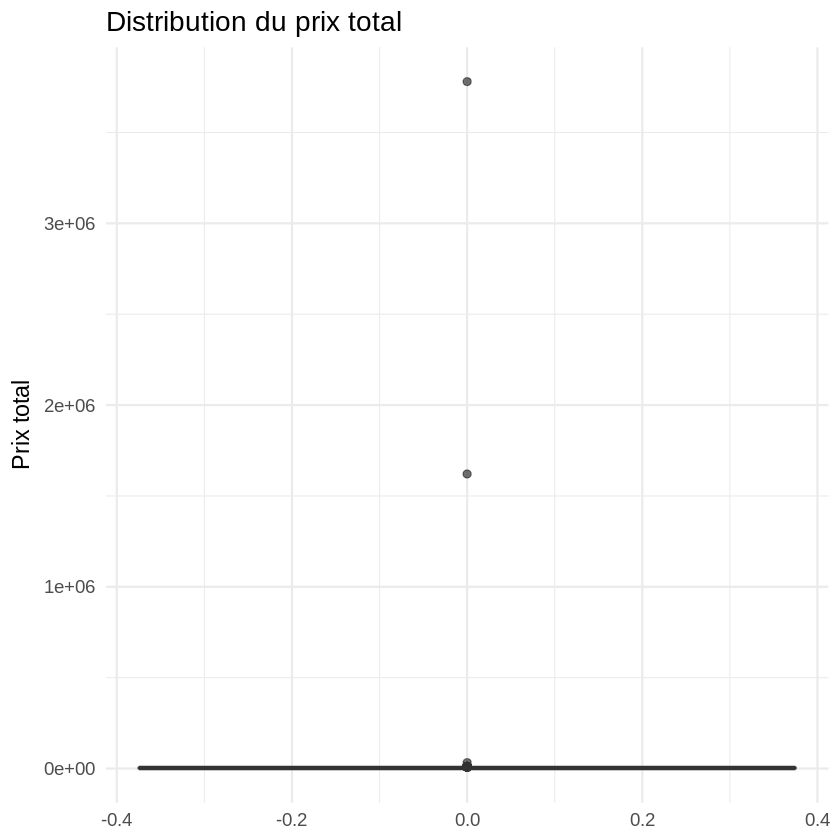

In [ ]:
ggplot(df_plot, aes(y = prix_total_num)) +
  geom_boxplot(fill = "#4CAF50", alpha = 0.7) +
  labs(
    title = "Distribution du prix total",
    y = "Prix total"
  ) +
  theme_minimal(base_size = 14)


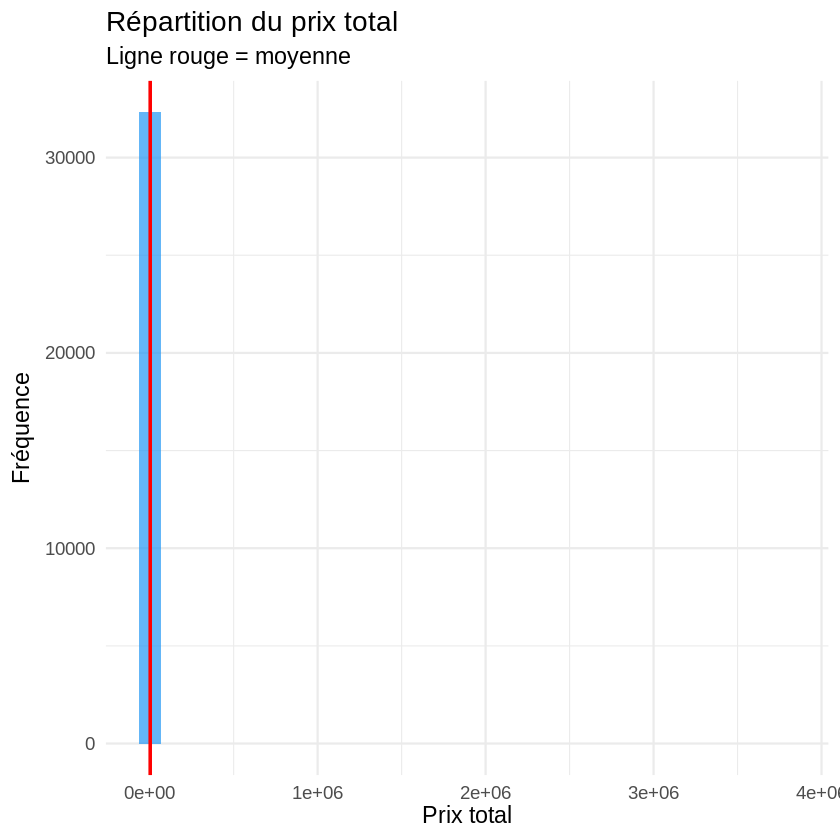

In [ ]:
moy <- mean(df_plot$prix_total_num)

ggplot(df_plot, aes(x = prix_total_num)) +
  geom_histogram(bins = 30, fill = "#2196F3", alpha = 0.7) +
  geom_vline(xintercept = moy, color = "red", linewidth = 1) +
  labs(
    title = "Répartition du prix total",
    subtitle = "Ligne rouge = moyenne",
    x = "Prix total",
    y = "Fréquence"
  ) +
  theme_minimal(base_size = 14)


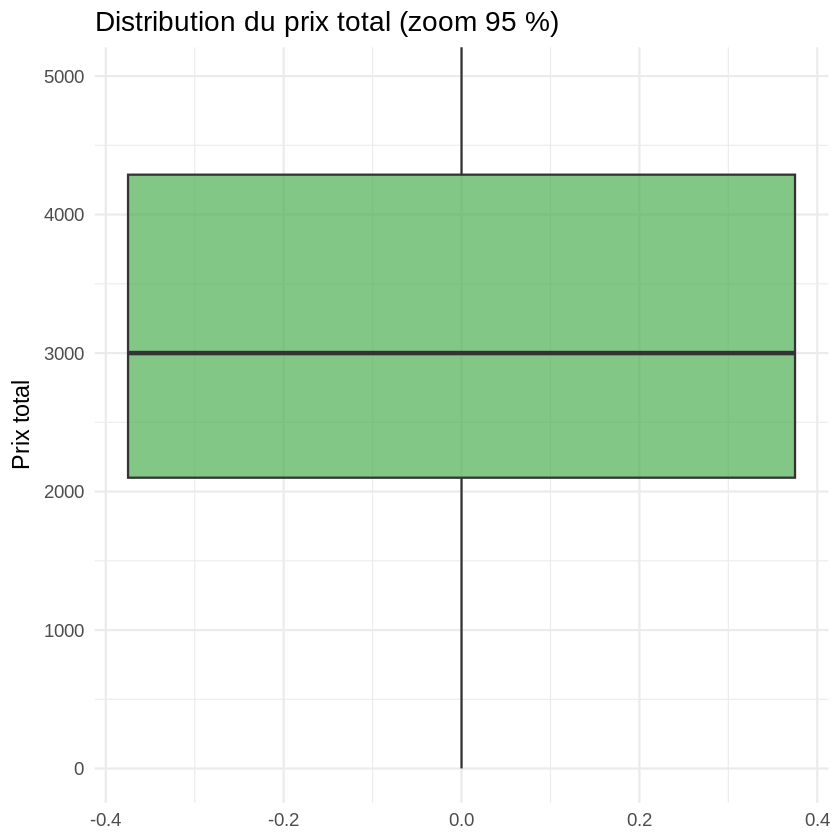

In [ ]:
p95 <- quantile(df_plot$prix_total_num, 0.95)

ggplot(df_plot, aes(y = prix_total_num)) +
  geom_boxplot(fill = "#4CAF50", alpha = 0.7, outlier.alpha = 0.2) +
  coord_cartesian(ylim = c(0, p95)) +
  labs(
    title = "Distribution du prix total (zoom 95 %)",
    y = "Prix total"
  ) +
  theme_minimal(base_size = 14)


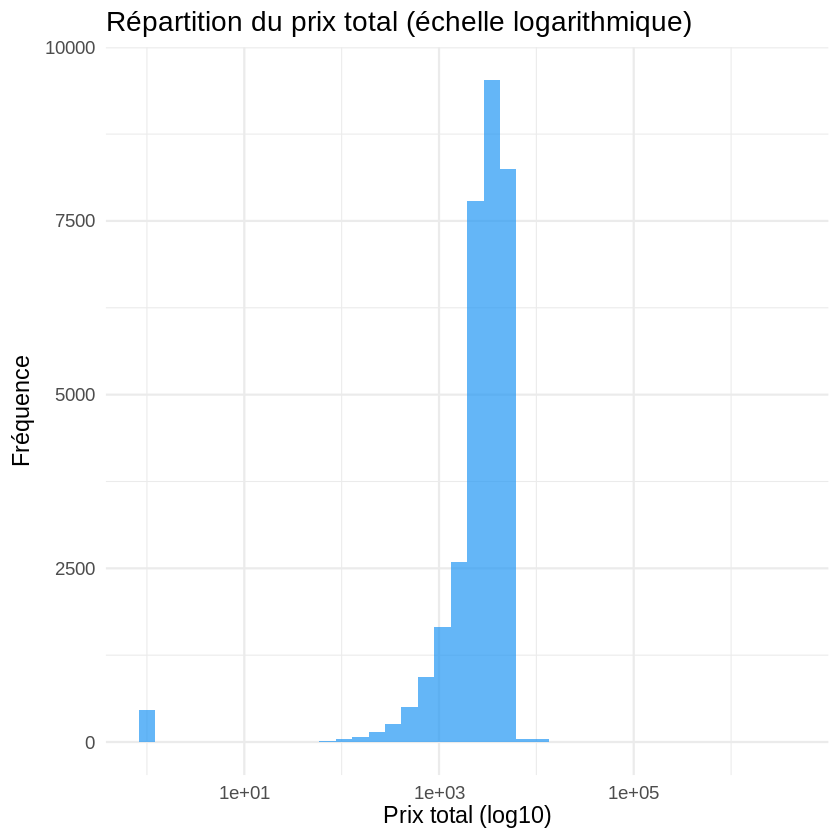

In [ ]:
ggplot(df_plot, aes(x = prix_total_num)) +
  geom_histogram(bins = 40, fill = "#2196F3", alpha = 0.7) +
  scale_x_log10() +
  labs(
    title = "Répartition du prix total (échelle logarithmique)",
    x = "Prix total (log10)",
    y = "Fréquence"
  ) +
  theme_minimal(base_size = 14)


### Évolution temporelle du prix moyen


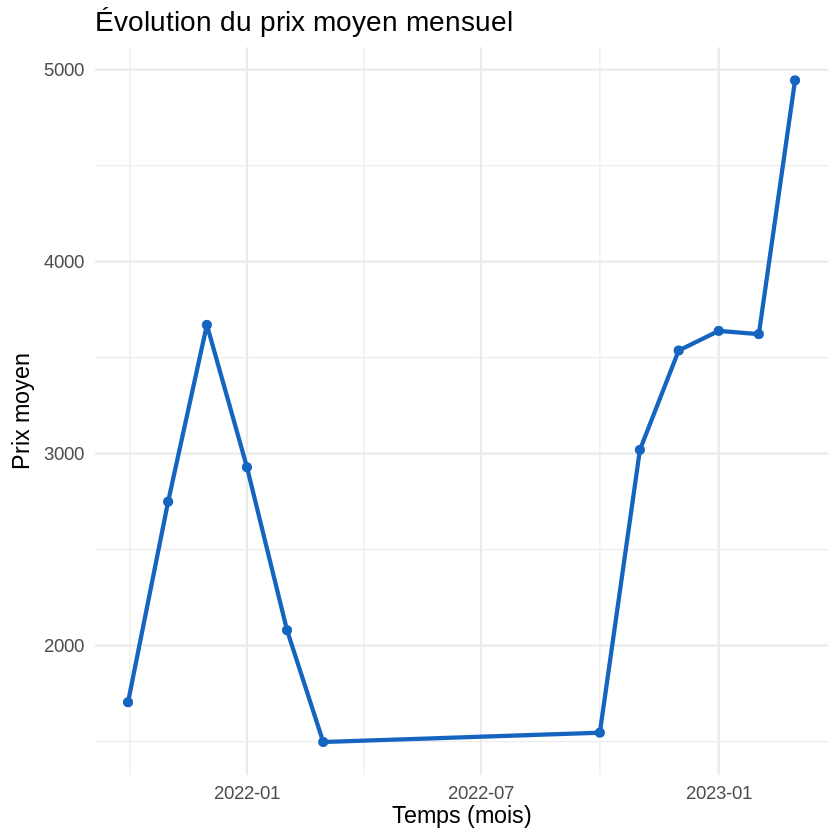

In [ ]:
library(lubridate)
library(dplyr)
library(ggplot2)

df_month <- df_plot %>%
  mutate(mois = floor_date(date_entree, "month")) %>%
  group_by(mois) %>%
  summarise(prix_moyen = mean(prix_total_num, na.rm = TRUE)) %>%
  arrange(mois)

ggplot(df_month, aes(x = mois, y = prix_moyen)) +
  geom_line(color = "#1565C0", linewidth = 1.2) +
  geom_point(color = "#1565C0", size = 2) +
  labs(
    title = "Évolution du prix moyen mensuel",
    x = "Temps (mois)",
    y = "Prix moyen"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
library(dplyr)

top_produits <- df_plot %>%
  group_by(libelle_produit) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 5) %>%
  pull(libelle_produit)

df_prod <- df_plot %>%
  filter(libelle_produit %in% top_produits)


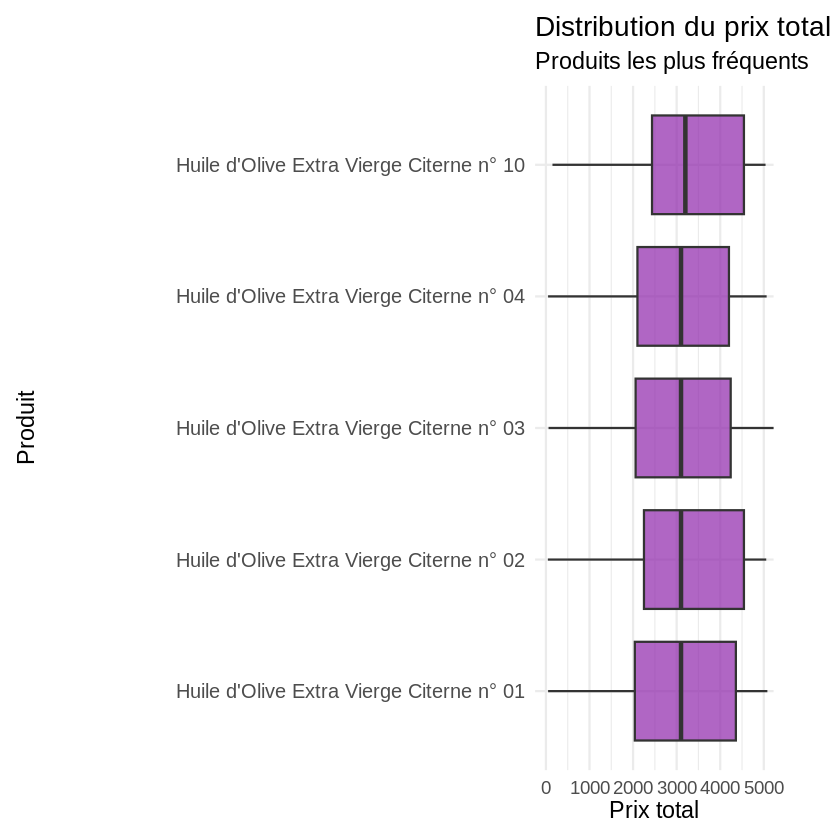

In [ ]:
ggplot(df_prod, aes(
  y = reorder(libelle_produit, prix_total_num, FUN = median),
  x = prix_total_num
)) +
  geom_boxplot(fill = "#8E24AA", alpha = 0.7, outlier.alpha = 0.2) +
  coord_cartesian(xlim = c(0, p95_prod)) +
  labs(
    title = "Distribution du prix total par produit (Top 5)",
    subtitle = "Produits les plus fréquents",
    y = "Produit",
    x = "Prix total"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(size = 12),
    plot.margin = margin(10, 40, 10, 10)
  )


`geom_smooth()` using formula = 'y ~ x'


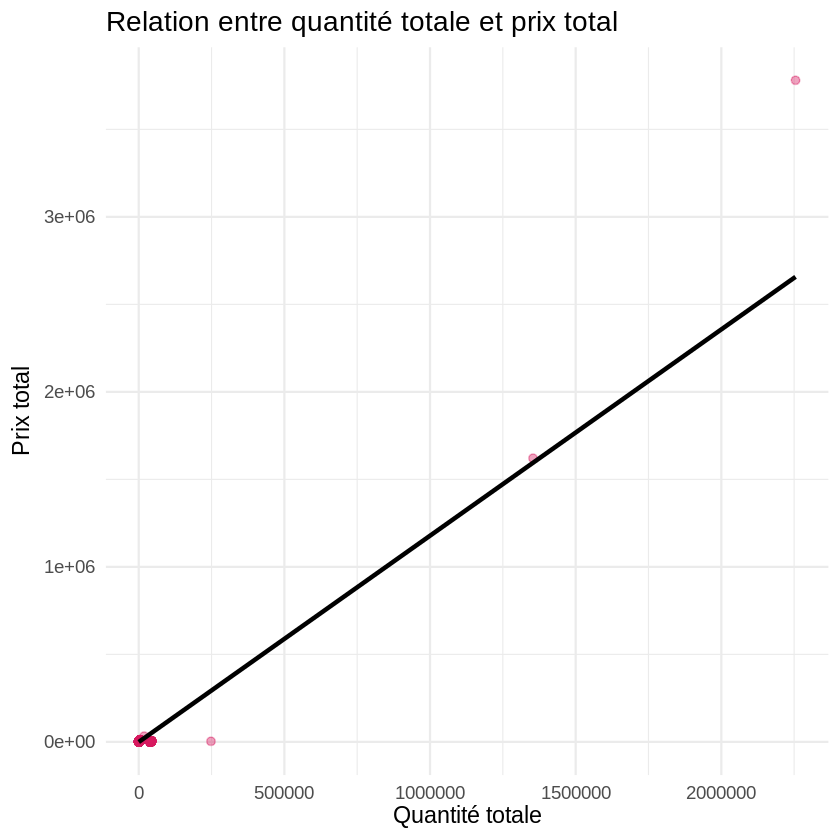

In [ ]:
ggplot(df_plot, aes(x = qte_totale, y = prix_total_num)) +
  geom_point(alpha = 0.4, color = "#D81B60") +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(
    title = "Relation entre quantité totale et prix total",
    x = "Quantité totale",
    y = "Prix total"
  ) +
  theme_minimal(base_size = 14)


## Conclusion
L’analyse statistique a permis de mieux comprendre la distribution
des prix, leur évolution dans le temps et leur relation avec les
quantités traitées.


## Perspectives
- Ajouter une analyse par fournisseur ou provenance
- Étudier la saisonnalité sur plusieurs années
- Détecter automatiquement les anomalies
- Construire un modèle prédictif du prix total
